# upload models

In [1]:
import torch
import torch.nn as nn
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np

# Number of channels in the training images. For color images this is 3
nc = 1
# Size of z latent vector (i.e. size of generator input)
nz = 100
# Size of feature maps in generator
ngf = 32
# Size of feature maps in discriminator
ndf = 32
# number of gpu
ngpu = 1

In [2]:
# upload netG and netD form models folder
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.GroupNorm(min(32, ndf * 8), ndf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.GroupNorm(min(32, ndf * 4), ndf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.GroupNorm(min(32, ndf * 2), ndf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.GroupNorm(min(32, ndf), ndf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh(),
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output

netG = Generator(ngpu)

# load weights
type = "non_private"
folder = f"models/{type}/"
netG.load_state_dict(torch.load(folder + 'netG.pth'))
# netD.load_state_dict(torch.load(folder + 'netD.pth'))


<All keys matched successfully>

## Generate a sample image

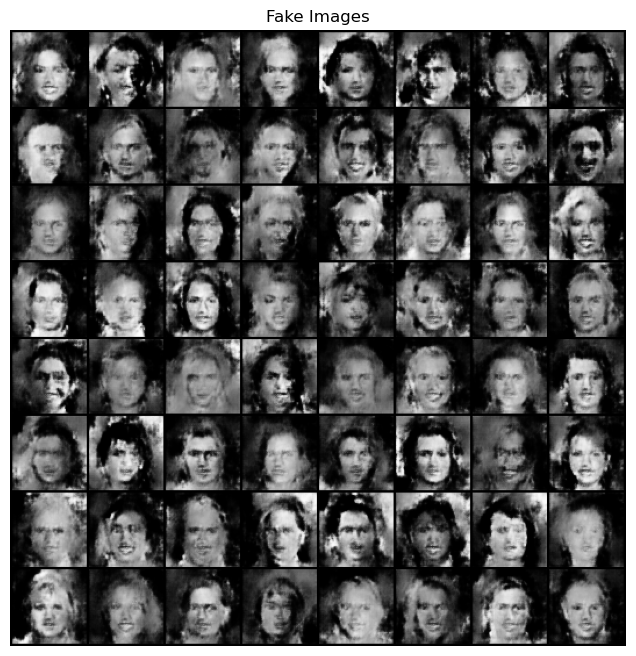

In [3]:
# Generate batch of latent vectors
noise = torch.randn(64, nz, 1, 1)
# Generate a batch of fake images
fake = netG(noise)
# Plot the fake images
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(vutils.make_grid(fake.detach().cpu(), padding=2, normalize=True), (1, 2, 0)))

# Upload images during training

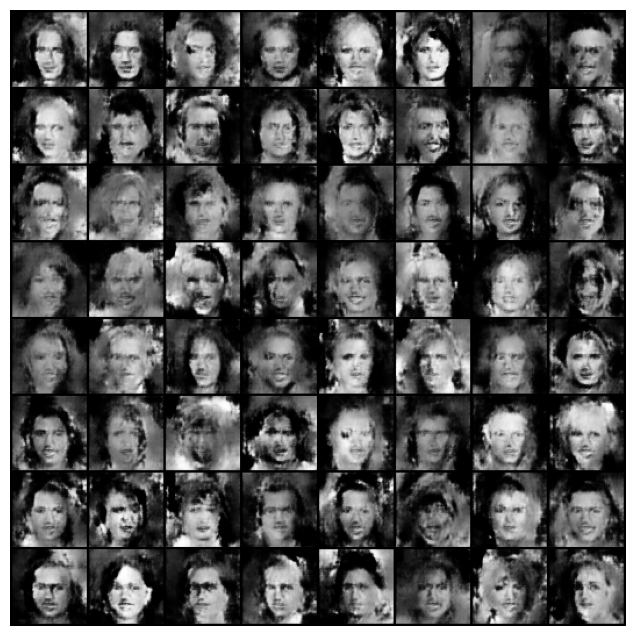

In [4]:
import matplotlib.animation as animation
from IPython.display import HTML

# import img_list.pth
img_list = torch.load(f'models/{type}/img_list.pth')
# plot
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

# Upload data

In [5]:
dataroot = "../data/Images/celeba_dataset/celeba"
imageSize = 64
batch_size = 1000
workers = 0
device = 'mps'

nc = 1
if nc == 1:
    # black and white
    transform_list = [
        transforms.Resize(imageSize),
        transforms.CenterCrop(imageSize),
        transforms.Grayscale(num_output_channels=1), # Convert image to grayscale
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)), # Normalize for 1 channel
    ]
else:
    # colors
    transform_list = [
        transforms.Resize(imageSize),
        transforms.CenterCrop(imageSize),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # Normalize for 3 channels
    ]

try:
    dataset = dset.ImageFolder(root=dataroot,
                               transform=transforms.Compose(transform_list))
    # Create the dataloader
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                             shuffle=True, num_workers=workers)
except:
    raise ValueError("Error in the dataset uploading")

## Sample an image from the dataset

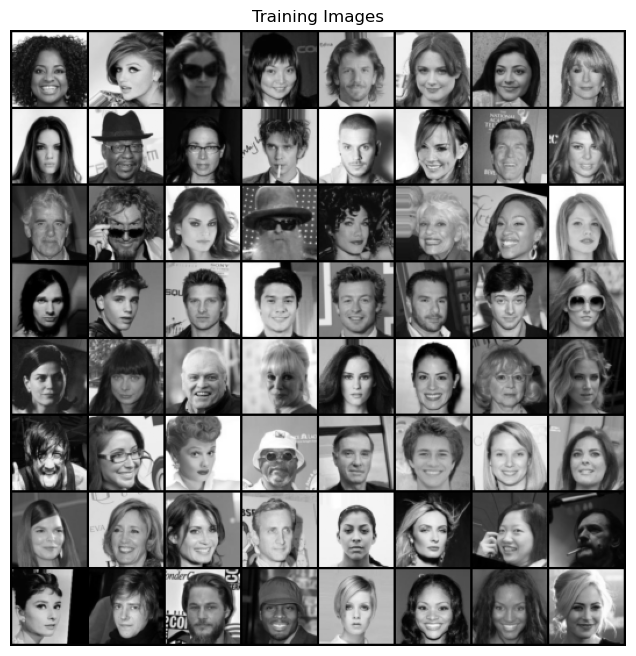

In [6]:
# get a batch of real images
real_batch = next(iter(dataloader))
# visualize the images
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(), (1, 2, 0)))

# Compute MiFDI

In [11]:
import torch
from torchmetrics.image.mifid import MemorizationInformedFrechetInceptionDistance

mifid = MemorizationInformedFrechetInceptionDistance(feature=64, normalize=True)

# generate batch_size fake images
noise = torch.randn(batch_size, nz, 1, 1)
fake = netG(noise)

# get the first batch_size real images
real = real_batch[0]

# Convert grayscale images to RGB by repeating the single channel three times
fake_rgb = fake.repeat(1, 3, 1, 1)  # This changes shape from [batch_size, 1, H, W] to [batch_size, 3, H, W]
real_rgb = real.repeat(1, 3, 1, 1)  # Ditto for real images

mifid.update(fake_rgb, real=False)
mifid.update(real_rgb, real=True)
metric = mifid.compute()
# print the metric
print("The MiFID is for the non private model is: ", metric.item())

The MiFID is for the non private model is:  2460.37548828125


## Compute FID

In [12]:
from torchmetrics.image.fid import FrechetInceptionDistance
fid = FrechetInceptionDistance(feature=64, normalize=True)
fid.update(real_rgb, real=True)
fid.update(fake_rgb, real=False)
metric = fid.compute()
print("The FID is for the non private model is: ", metric.item())

The FID is for the non private model is:  1.5842418670654297


# Compute for private generative model

In [13]:
netG_dp = Generator(ngpu)

# load weights
type = "private"
folder = f"models/{type}/"
netG_dp.load_state_dict(torch.load(folder + 'netG.pth'))

<All keys matched successfully>

## Example of private generative image

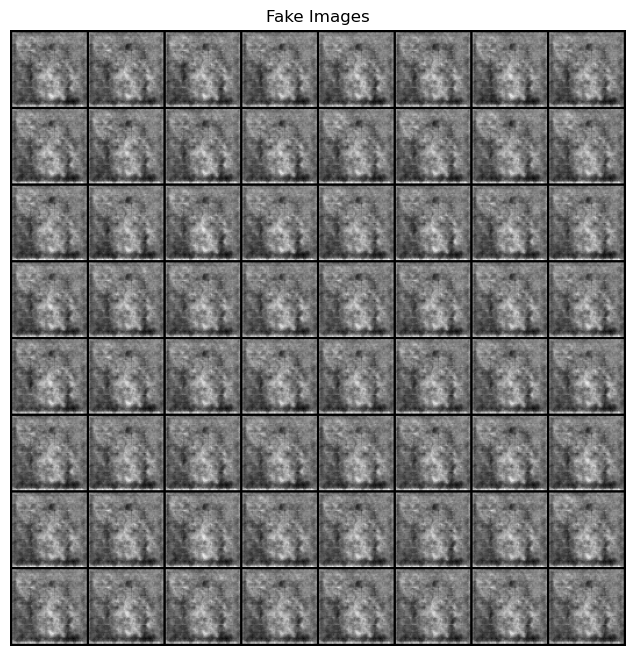

In [14]:
# Generate batch of latent vectors
noise = torch.randn(64, nz, 1, 1)
# Generate a batch of fake images
fake = netG_dp(noise)
# Plot the fake images
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(vutils.make_grid(fake.detach().cpu(), padding=2, normalize=True), (1, 2, 0)))

## Compute MiFID

In [15]:
import torch
from torchmetrics.image.mifid import MemorizationInformedFrechetInceptionDistance

mifid = MemorizationInformedFrechetInceptionDistance(feature=64, normalize=True)

# generate batch_size fake images
noise = torch.randn(batch_size, nz, 1, 1)
fake = netG_dp(noise)

# get the first batch_size real images
real = real_batch[0]

# Convert grayscale images to RGB by repeating the single channel three times
fake_rgb = fake.repeat(1, 3, 1, 1)  # This changes shape from [batch_size, 1, H, W] to [batch_size, 3, H, W]
real_rgb = real.repeat(1, 3, 1, 1)  # Ditto for real images

mifid.update(fake_rgb, real=False)
mifid.update(real_rgb, real=True)
metric = mifid.compute()
# print the metric
print("The MiFID is for the private model is: ", metric.item())

The MiFID is for the private model is:  535.9788818359375


## Compute FID

In [16]:
from torchmetrics.image.fid import FrechetInceptionDistance
fid = FrechetInceptionDistance(feature=64, normalize=True)
fid.update(real_rgb, real=True)
fid.update(fake_rgb, real=False)
metric = fid.compute()
print("The FID is for the private model is: ", metric.item())

The FID is for the private model is:  4.8086748123168945


Note the the FID for the private model is higher than the non private model. This is expected since the private model is trained with differential privacy which adds noise to the gradients and thus the model is less accurate.However, the MiFID is lower for the private model, as the generative model does not memorize the training data.

# MiFID on white noise

In [17]:
def weights_init(m):
    # it initially searches the class name of the module and then initializes the weights
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        # sample from normal distribution with mean 0 and standard deviation 0.02
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        # sample from normal distribution with mean 1 and standard deviation 0.02
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        
netG = Generator(ngpu)
netG.apply(weights_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): GroupNorm(32, 256, eps=1e-05, affine=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): GroupNorm(32, 128, eps=1e-05, affine=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): GroupNorm(32, 64, eps=1e-05, affine=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): GroupNorm(32, 32, eps=1e-05, affine=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [20]:
import torch
from torchmetrics.image.mifid import MemorizationInformedFrechetInceptionDistance

mifid = MemorizationInformedFrechetInceptionDistance(feature=64, normalize=True)

# generate batch_size fake images
noise = torch.randn(batch_size, nz, 1, 1)
fake = netG(noise)

# get the first batch_size real images
real = real_batch[0]

# Convert grayscale images to RGB by repeating the single channel three times
fake_rgb = fake.repeat(1, 3, 1, 1)  # This changes shape from [batch_size, 1, H, W] to [batch_size, 3, H, W]
real_rgb = real.repeat(1, 3, 1, 1)  # Ditto for real images

mifid.update(fake_rgb, real=False)
mifid.update(real_rgb, real=True)
metric = mifid.compute()
# print the metric
print("The MiFID is for the white noise model is: ", metric.item())

The MiFID is for the white noise model is:  2315.988037109375


In [21]:
from torchmetrics.image.fid import FrechetInceptionDistance
fid = FrechetInceptionDistance(feature=64, normalize=True)
fid.update(real_rgb, real=True)
fid.update(fake_rgb, real=False)
metric = fid.compute()
print("The FID is for the white noise model is: ", metric.item())

The FID is for the white noise model is:  56.0452995300293
